# 1. Web scraping (BeautifulSoup)

In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import requests

In [2]:
# Base URL without the offset parameter
base_url = 'https://www.booking.com/searchresults.html?label=gog235jc-1DCAEoggI46AdIM1gDaBGIAQGYATG4ARfIAQzYAQPoAQH4AQKIAgGoAgO4Aum8_60GwAIB0gIkZDE5MzNjYTEtYTgwZS00ODU3LWFiNmItZWFkODc2MDdjODdi2AIE4AIB&aid=397594&ss=United+States&lang=en-us&sb=1&src_elem=sb&src=index&dest_id=224&dest_type=country&ac_position=2&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=058e8574f1a6008f&ac_meta=GhAwNThlODU3NGYxYTYwMDhmIAIoATICZW46BnVuaXRlZEAASgBQAA%3D%3D&checkin=2024-02-04&checkout=2024-02-05&group_adults=2&no_rooms=1&group_children=0&selected_currency=USD&offset={}'

headers = {
    'User-Agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
    'Accept-Language': 'en-US, en;q=0.5'
}


In [3]:
hotel_results = []

# Loop through pages 1 to 40
for page_number in range(0, 250,25):
    url = base_url.format(page_number)
    
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    for el in soup.find_all("div", {"data-testid": "property-card"}):
        hotel_results.append({
            "name": el.find("div", {"data-testid": "title"}).text.strip(),
            'description': el.find('div', {'data-testid': 'recommended-units', 'class': 'ccdd44706b'}).text.strip(),
            "location": el.find("span", {"data-testid": "address"}).text.strip(),
            "pricing": el.find("span", {"data-testid": "price-and-discounted-price"}).text.strip(),
            "rating": el.find("div", {"data-testid": "review-score"}).text.strip().split(" ")[0],
        })

# Create DataFrame from the collected results
hotels = pd.DataFrame(hotel_results)

In [5]:
hotels.head()

,name,description,location,pricing,rating
0,Room in Single Family House - Suburban Neighbo...,Queen Room with Shared Bathroom1 queen bedOnly...,Boston,US$76,9.2Wonderful
1,B Ocean Resort,Chic City View King Accessible with Roll-in Sh...,"Fort Lauderdale Beach, Fort Lauderdale",US$121,6.9Review
2,The Read House,The Manor - Accessible Double Queen 2 queen beds,"City Center, Chattanooga",US$134,9.0Wonderful
3,Seahaven Beach Hotel Panama City Beach,Two Room SuitePrivate suite • 2 bedrooms • 1 l...,Panama City Beach,US$63,4.6Review
4,San Mateo Inn,Double Room with Two Double Beds - Non-Smoking...,Albuquerque,US$63,7.7Good


# 2. Data Discovering and some analysis

In [17]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 0 to 249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         249 non-null    object 
 1   description  249 non-null    object 
 2   location     249 non-null    object 
 3   pricing      249 non-null    float64
 4   rating       249 non-null    float64
dtypes: float64(2), object(3)
memory usage: 11.7+ KB


In [8]:
hotels['pricing'] = hotels['pricing'].str.replace('US\$', '').astype(float)
hotels['rating'] = hotels['rating'].str.extract('(\d+\.\d+)')
# Convert the 'rating' column to numeric
hotels['rating'] = pd.to_numeric(hotels['rating'], errors='coerce')

C:\Users\ASUS\AppData\Local\Temp/ipykernel_20072/3649766623.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  hotels['pricing'] = hotels['pricing'].str.replace('US\$', '').astype(float)


In [ ]:
# Drop rows with missing values in the 'rating' column
hotels.dropna(subset=['rating'],inplace=True)

In [18]:
# Descriptive statistics
print(hotels.describe())

# Unique values and value counts
print(hotels['location'].value_counts())

          pricing      rating
count  249.000000  249.000000
mean   114.449799    8.167068
std     51.403983    0.667113
min     39.000000    4.600000
25%     84.000000    7.800000
50%    101.000000    8.200000
75%    129.000000    8.700000
max    454.000000    9.600000
Spencer         3
Santa Rosa      3
Broken Bow      3
Yuma            3
Hildale         3
               ..
Tampa           1
Bryce Canyon    1
Gunnison        1
Natchez         1
Stevenson       1
Name: location, Length: 204, dtype: int64


In [20]:
# Correlation matrix
correlation_matrix = hotels.corr()
print(correlation_matrix)

         pricing   rating
pricing  1.00000  0.25791
rating   0.25791  1.00000


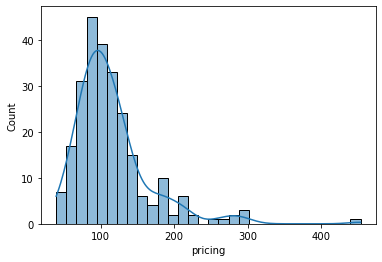

In [21]:
# Distribution plot for pricing
sns.histplot(hotels['pricing'], kde=True)
plt.show()

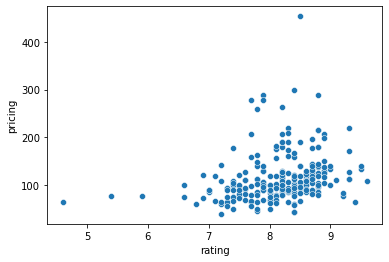

In [22]:
# Scatter plot for rating vs pricing
sns.scatterplot(data=hotels, x='rating', y='pricing')
plt.show()

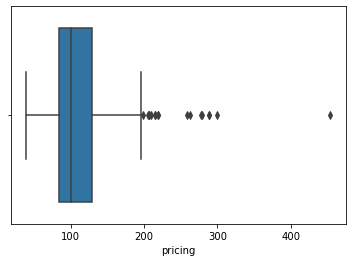

In [23]:
# Box plot for 'pricing'
sns.boxplot(x=hotels['pricing'])
plt.show()

# 3. Modelling before outlier detection

In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hotels[['rating']], hotels['pricing'], test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 1016.5779957905075
R-squared: 0.033899223994536265


In [25]:
Q1 = hotels['pricing'].quantile(0.25)
Q3 = hotels['pricing'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

count_outliers = hotels[(hotels['pricing'] < lower_bound) | (hotels['pricing'] > upper_bound)].shape[0]

print(f'Number of outliers in pricing: {count_outliers}')


Number of outliers in pricing: 17


In [26]:
Q1 = hotels['pricing'].quantile(0.25)
Q3 = hotels['pricing'].quantile(0.75)
IQR = Q3 - Q1


In [27]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = hotels[(hotels['pricing'] < lower_bound) | (hotels['pricing'] > upper_bound)]
# Remove outliers
hotels_no_outliers = hotels[(hotels['pricing'] >= lower_bound) & (hotels['pricing'] <= upper_bound)]

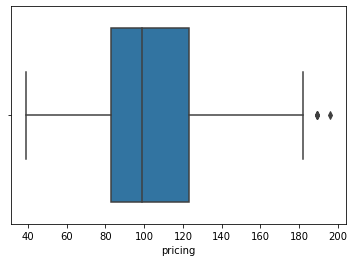

In [28]:
# Box plot for 'pricing'
sns.boxplot(x=hotels_no_outliers['pricing'])
plt.show()

# 4. Modelling after removing outliers and choosing best model

In [29]:
# Prepare the data
X = hotels_no_outliers[['rating']]
y = hotels_no_outliers['pricing']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r_squared = r2_score(y_test, predictions)
    results[model_name] = {'MSE': mse, 'R-squared': r_squared}

# Print the results
for model_name, scores in results.items():
    print(f"{model_name} - MSE: {scores['MSE']}, R-squared: {scores['R-squared']}")

# Choose the best model based on MSE or R-squared (based on preference)
best_model = min(results, key=lambda k: results[k]['MSE'])
print(f"\nBest Model based on MSE: {best_model}")


Linear Regression - MSE: 712.2621284944237, R-squared: 0.1811459877466589
Decision Tree Regressor - MSE: 859.3915361915411, R-squared: 0.011998280753017454
Random Forest Regressor - MSE: 801.8887215901107, R-squared: 0.07810654141791107
Gradient Boosting Regressor - MSE: 835.3452136682051, R-squared: 0.03964319810920647

Best Model based on MSE: Linear Regression
